<a href="https://colab.research.google.com/github/Gabriele90/ML-in-medical-imaging/blob/main/Visualizing_and_Understanding_CNN_in_MRI_brain_tumor_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Visualizing and Understanding
CNN in MRI brain tumor images***

***Introduction***

Large Convolutional Network models have recently demonstrated impressive classification performance on the medical images like as MRI, PET, CT-scans and whole slide images (histopathological images).
However there is no clear understanding of why they perform so well, or how they might be improved. In this study I introduce a novel visualization technique that gives a step by step description on how we can extract features from hidden conv. layers using Keras (running on top of TensorFlow).

Visualizing features to gain intuition about the network is common practice, but mostly limited to the 1st layer where projections to pixel space are possible. In higher layers alternate methods must be used. This requires a careful initialization and does not give any information about the unit’s invariances. The problem is that for higher layers, the invariances are extremely complex so are poorly captured by a simple quadratic approximation.

We use standard fully supervised convnet called VGG16 model throughout the study.



***Objectives***

I pose two different objectives:

1. Extract hidden conv. layer outputs using Keras.
2. Present two different ways to tile these outputs to form a compact image.

***Importing libraries***

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import os 
import tqdm
import glob
import tensorflow 

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import grey2rgb

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.utils import to_categorical
from keras import optimizers

from keras.callbacks import Callback,ModelCheckpoint
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K

from tensorflow.keras.metrics import Metric
import cv2
import random
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator

***Importing dataset***

The dates contains MRI data. The images are already split into 4 categories: Glioma, Pituitary tumor, Meningioma, and no tumor.

In [3]:
#clone the dataset from the github repository
! git clone https://github.com/sartajbhuvaji/brain-tumor-classification-dataset

Cloning into 'brain-tumor-classification-dataset'...
remote: Enumerating objects: 3039, done.
remote: Total 3039 (delta 0), reused 0 (delta 0), pack-reused 3039
Receiving objects: 100% (3039/3039), 79.25 MiB | 32.42 MiB/s, done.


***Setting the working directories***

In [4]:

#set the path to the main dir
import os
main_dir = "/content/brain-tumor-classification-dataset"
#set the path to the train dir
train_dir = os.path.join(main_dir,'Training')
#set the path to the test dir
test_dir = os.path.join(main_dir,'Testing')
#directory with the training glioma images
train_glioma_dir = os.path.join(train_dir, 'glioma_tumor')
#directory with the training meningioma images
train_meningioma_dir = os.path.join(train_dir, 'meningioma_tumor')
#directory with the training pituitary images
train_pituitary_dir = os.path.join(train_dir, 'pituitary_tumor')
#directory with the training no_tumor images
train_no_tumor_dir = os.path.join(train_dir, 'no_tumor')
#directory with the testing covid images
test_glioma_dir = os.path.join(test_dir, 'glioma_tumor')
#directory with the testing meningioma images
test_meningioma_dir = os.path.join(test_dir, 'meningioma_tumor')
#directory with the testing pituitary images
test_pituitary_dir = os.path.join(test_dir, 'pituitary_tumor')
#directory with the training no_tumor images
test_no_tumor_dir = os.path.join(test_dir, 'no_tumor')

In [5]:
train_meningioma_names = os.listdir(train_meningioma_dir)
print(train_meningioma_names[:5])

train_glioma_names = os.listdir(train_glioma_dir)
print(train_glioma_names[:5])

train_pituitary_names = os.listdir(train_pituitary_dir)
print(train_meningioma_names[:5])

train_no_tumor_names = os.listdir(train_no_tumor_dir)
print(train_no_tumor_names[:5])

test_meningioma_names = os.listdir(test_meningioma_dir)
print(test_meningioma_names[:5])

test_glioma_names = os.listdir(test_glioma_dir)
print(test_glioma_names[:5])

test_pituitary_names = os.listdir(test_pituitary_dir)
print(test_meningioma_names[:5])

test_no_tumor_names = os.listdir(test_no_tumor_dir)
print(test_no_tumor_names[:5])

['m2 (100).jpg', 'm2 (15).jpg', 'm (19).jpg', 'm3 (28).jpg', 'm2 (66).jpg']
['gg (479).jpg', 'gg (536).jpg', 'gg (236).jpg', 'gg (338).jpg', 'gg (386).jpg']
['m2 (100).jpg', 'm2 (15).jpg', 'm (19).jpg', 'm3 (28).jpg', 'm2 (66).jpg']
['image(287).jpg', 'image(239).jpg', 'image(43).jpg', 'image (57).jpg', 'image(7).jpg']
['image(43).jpg', 'image(7).jpg', 'image(59).jpg', 'image(9).jpg', 'image(46).jpg']
['image(43).jpg', 'image(7).jpg', 'image(59).jpg', 'image(9).jpg', 'image(46).jpg']
['image(43).jpg', 'image(7).jpg', 'image(59).jpg', 'image(9).jpg', 'image(46).jpg']
['image(43).jpg', 'image(7).jpg', 'image(59).jpg', 'image(9).jpg', 'image(46).jpg']


In [6]:
#print the total no of images present in each dir
print("Total images in the training set:", len(train_glioma_names+train_meningioma_names+train_no_tumor_names+train_pituitary_names))
print("Total images in the test set:", len(test_glioma_names+test_meningioma_names+train_no_tumor_names+train_pituitary_names))

Total images in the training set: 2870
Total images in the test set: 1437


***Visualizing data***

In [7]:
#get the filenames from the covid & normal dir of the train dataset
glioma_pic =[os.path.join(train_glioma_dir, filename) for filename in train_glioma_names[0:4]]
pituitary_pic =[os.path.join(train_pituitary_dir, filename) for filename in train_pituitary_names[0:4]]
meningioma_pic =[os.path.join(train_meningioma_dir, filename) for filename in train_meningioma_names[0:4]]
no_tumor_pic =[os.path.join(train_no_tumor_dir, filename) for filename in train_no_tumor_names[0:4]]

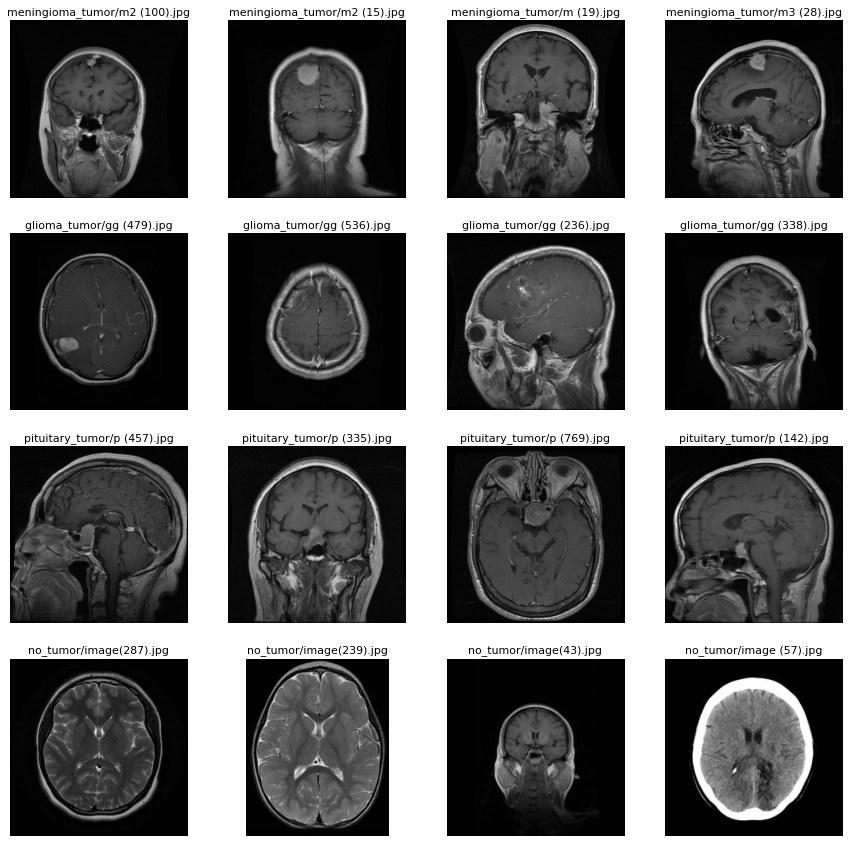

In [8]:
import matplotlib.pyplot as plt
# plot a grid of 16 images (2 images of each class)
import matplotlib.image as mpimg
#set the number of columns and rows
rows = 4
cols = 4
#set the figure size
fig = plt.gcf()
fig.set_size_inches(15,15)
#merge the covid and normal list
merged_list = meningioma_pic+glioma_pic+pituitary_pic+no_tumor_pic
for i , img_path in enumerate(merged_list):
  data= img_path.split('/', 4)[4]
  sp = plt.subplot(rows, cols, i + 1 )
  sp.axis('Off')
  img = mpimg.imread(img_path)
  sp.set_title(data, fontsize=11)
  plt.imshow(img,cmap='gray')

  plt.show

***Image Resizing***

We need to work with images of the same size. In  this case I decided to resizing all image 224x224.
For this task we use cv2.resize() from the ‘cv2’ library.

In [9]:
x = []
y = []

for i in tqdm(os.listdir(train_meningioma_dir)):
    path = os.path.join(train_meningioma_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    x.append(img)
    y.append('Meningioma')

for i in tqdm(os.listdir(train_glioma_dir)):
    path = os.path.join(train_glioma_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    x.append(img)
    y.append('Glioma')

for i in tqdm(os.listdir(train_pituitary_dir)):
    path = os.path.join(train_pituitary_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    x.append(img)
    y.append('Pituitary')   

for i in tqdm(os.listdir(train_no_tumor_dir)):
    path = os.path.join(train_no_tumor_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    x.append(img)
    y.append('No tumor')

100%|██████████| 395/395 [00:00<00:00, 415.56it/s]


In [10]:
for i in tqdm(os.listdir(test_meningioma_dir)):
    path = os.path.join(test_meningioma_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    x.append(img)
    y.append('Meningioma')

for i in tqdm(os.listdir(test_glioma_dir)):
    path = os.path.join(test_glioma_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    x.append(img)
    y.append('Glioma')

for i in tqdm(os.listdir(test_pituitary_dir)):
    path = os.path.join(test_pituitary_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    x.append(img)
    y.append('Pituitary')   

for i in tqdm(os.listdir(test_no_tumor_dir)):
    path = os.path.join(test_no_tumor_dir,i)
    img = cv2.imread(path)
    img = cv2.resize(img,(224,224))
    x.append(img)
    y.append('No tumor')

100%|██████████| 105/105 [00:00<00:00, 890.36it/s]


In [11]:
x = np.array(x)
y = np.array(y)
x.shape,y.shape

((3264, 224, 224, 3), (3264,))

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


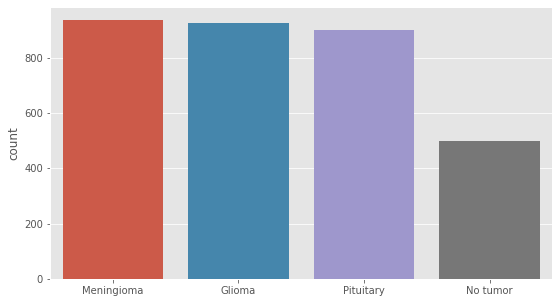

In [12]:
import seaborn as sns
plt.style.use("ggplot")
plt.figure(figsize=(9,5))
sns.countplot(y)
plt.show()

***Hotlabel encoding***

In [13]:
y

array(['Meningioma', 'Meningioma', 'Meningioma', ..., 'No tumor',
       'No tumor', 'No tumor'], dtype='<U10')

In [14]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(y)

In [15]:
y = to_categorical(y)#num_classes = 4
y.shape

(3264, 4)

In [16]:
from sklearn.utils import shuffle
x,y = shuffle(x,y)

***Data splitting***

When developing a deep learning-based method, using a rigorous evaluation process is essential to avoid overfitting to training data or the generation of fake information. In order to evaluate the performance of the network, it is generally recommended to split data into training, valid, and test sets. The training set data are used to determine the network parameters. In most cases, the network shows good performance for the training set after an iterative learning process with the proper adjustment
of the network structure and its hyperparameters, due to
its very high capacity. Therefore, the separate validation
set is required to predict the general performance of the
network. The data in the validation set should not be fed
into the network because the model should have the ability
to apply external data not included in the training process.

In [17]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)
y_test.shape

(653, 4)

***Data Augmentation***

The amount of data gathered was very low and could cause the models to under-fit. Hence, we would use a brilliant technique of Data Augmentation to increase the amount of data. This technique relies on rotations, flips, change in exposure, etc to create similar images. Using this technique we can increase the size of data by a high factor. The output image of the cropping stage is given as input to ImageDataGenerator which is a function in keras.preprocessing.image library. This function takes multiple arguments that decide how Augmentation takes place.

In [18]:
img_size=224
train_datagen = ImageDataGenerator(rotation_range=30,height_shift_range=0.2,
                                  zoom_range = 0.3,horizontal_flip=True)#rescale=(1./255),
test_datagen = ImageDataGenerator()#rescale=(1./255)

train_gen = train_datagen.flow_from_directory(directory = train_dir,target_size=(img_size,img_size),class_mode ="categorical",
                                              batch_size=32)
test_gen = test_datagen.flow_from_directory(directory = test_dir,target_size=(img_size,img_size),class_mode ="categorical",
                                              batch_size=32)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


***Showing the generated data***

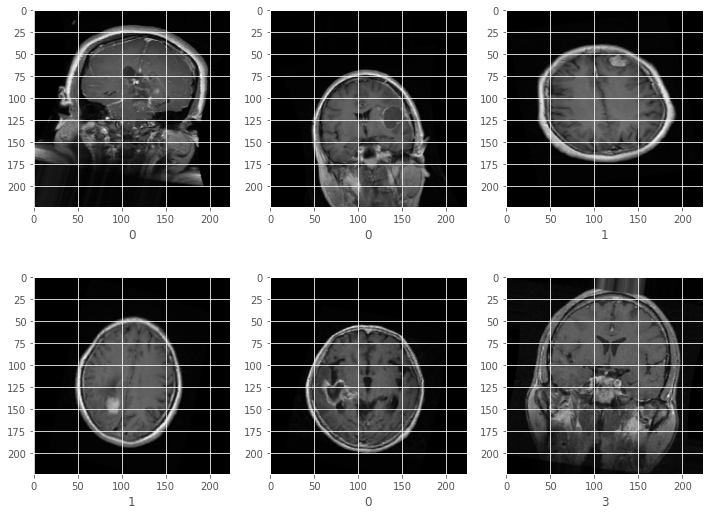

In [19]:
from tensorflow.keras.preprocessing import image
sample_x,sample_y = next(train_gen)
plt.figure(figsize=(12,9))
for i in range(6):
    plt.subplot(2,3,i+1)
    sample = image.array_to_img(sample_x[i])
    plt.xlabel(np.argmax(sample_y[i]))
    plt.imshow(sample)
plt.show()

In [20]:
#get the class indices
train_gen.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

In [21]:
#get the image shape
train_gen.image_shape

(224, 224, 3)

In [22]:
#get the class indices
train_gen.class_indices

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

***Importing more libraries for model building***

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as numpy
import matplotlib.pyplot as pyplot
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten,\
 Conv2D, MaxPooling2D,BatchNormalization,LayerNormalization

***VGG16 Model***

The VGG-16 which has 13 convolutional and 3 fully-connected layers, carrying with them the ReLU tradition from AlexNet. This network stacks more layers onto AlexNet, and use smaller size filters (2×2 and 3×3). It consists of 138M parameters and takes up about 500MB of storage space.

However, to finish training faster, I used a model which is more like a **mini-version of VGG16 architecture (2 layers of conv. layers followed by a pooling layer)**, with input size set to (224, 224).

In [48]:
model = models.Sequential([
                           layers.Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3) ),
                           layers.Conv2D(16, (3, 3), activation='relu', padding='same', name='block0_conv2'), 
                           layers.MaxPooling2D((2, 2), strides=(2, 2), name='block0_pool1'), #end of block 0
                           layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv1'),
                           layers.Conv2D(32, (3, 3), activation='relu', padding='same', name='block1_conv2'), 
                           layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool1'), 
                           layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1'), 
                           layers.Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv2'), 
                           layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool1'), # end of block2
                           layers.Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1'), 
                           layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'), # end of block3, we use only 3 blocks
                           layers.Flatten(),
                           layers.Dense(512, activation='relu'), 
                           layers.Dropout(0.4, name='Dropout_1'), 
                           layers.Dense(4, activation='softmax')
                                 ])

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 16)      448       
_________________________________________________________________
block0_conv2 (Conv2D)        (None, 224, 224, 16)      2320      
_________________________________________________________________
block0_pool1 (MaxPooling2D)  (None, 112, 112, 16)      0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 112, 112, 32)      4640      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 112, 112, 32)      9248      
_________________________________________________________________
block1_pool1 (MaxPooling2D)  (None, 56, 56, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 56, 56, 64)       

For the first layer, input image size is (224, 224) with 3 channels (n_c). The filter size (f) is (3, 3) and number of filters (n_f) are 16. So the total number of weights (f× f × n_f × n_c) = 432. Number of biases = n_f = 16. Total number of parameters = 448. Similarly for the second layer we have — weights = (3× 3 × 16 × 16) = 2304, biases = 16, so, total number of parameters = 2320 and so on.

***Defining callbacks***

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

checkpoint = ModelCheckpoint( "VGG16" ,monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'auto', verbose = 1)

***Compiling and training the model***

In [30]:
model.compile(optimizer=Adam(lr=0.0001),loss="categorical_crossentropy",metrics = ["accuracy"])

In [31]:
#train the VGG16 model

history = model.fit(x_train,y_train,epochs=100,validation_data = (x_test,y_test),verbose=1,
                              callbacks=[checkpoint,reduce_lr])

Epoch 1/100
82/82 [==============================] - 20s 43ms/step - loss: 5.1149 - accuracy: 0.3893 - val_loss: 0.8863 - val_accuracy: 0.6478

Epoch 00001: val_accuracy improved from -inf to 0.64778, saving model to VGG16
INFO:tensorflow:Assets written to: VGG16/assets
Epoch 2/100
82/82 [==============================] - 3s 34ms/step - loss: 0.8498 - accuracy: 0.6571 - val_loss: 0.6543 - val_accuracy: 0.7580

Epoch 00002: val_accuracy improved from 0.64778 to 0.75804, saving model to VGG16
INFO:tensorflow:Assets written to: VGG16/assets
Epoch 3/100
82/82 [==============================] - 3s 34ms/step - loss: 0.5858 - accuracy: 0.7793 - val_loss: 0.5593 - val_accuracy: 0.7764

Epoch 00003: val_accuracy improved from 0.75804 to 0.77642, saving model to VGG16
INFO:tensorflow:Assets written to: VGG16/assets
Epoch 4/100
82/82 [==============================] - 3s 34ms/step - loss: 0.4226 - accuracy: 0.8409 - val_loss: 0.4672 - val_accuracy: 0.8407

Epoch 00004: val_accuracy improved from 

After training the model for 100 epochs we got a good validation accuracy of 92%.

***Visualizing model performance***

In [32]:
#get the keys of history object
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [33]:
epochs=100
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

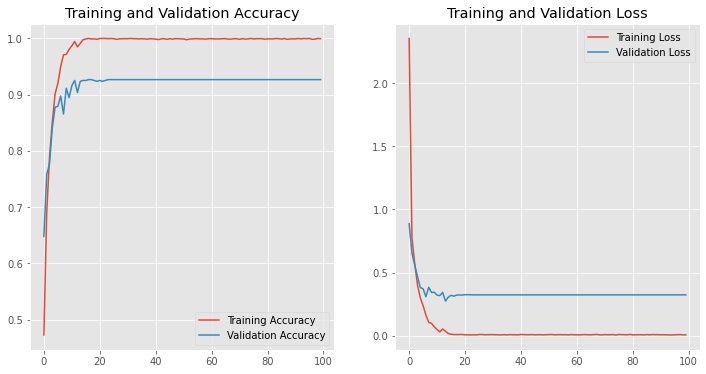

In [50]:
plot_history(history)

***Prediction of new images taken from  the test set***

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


result vector:  [[7.76701029e-07 9.99987006e-01 3.08840345e-06 9.02940337e-06]
 [9.99968886e-01 1.45009972e-05 1.66213213e-05 6.74373057e-10]
 [9.79468506e-09 9.99991775e-01 8.23407026e-06 7.56121055e-10]
 [3.41273961e-04 9.99563158e-01 9.55758296e-05 8.01295386e-09]
 [9.99170780e-01 7.83487340e-04 4.56749185e-05 2.79074310e-08]
 [9.99997139e-01 2.45781030e-06 3.02669349e-07 1.34315420e-10]
 [3.75440373e-11 6.99510778e-08 3.90174186e-08 9.99999881e-01]
 [5.86436281e-12 3.75365225e-11 1.55125923e-09 1.00000000e+00]
 [1.32149280e-09 5.13516400e-12 1.60010867e-08 1.00000000e+00]
 [3.03685738e-06 9.48492307e-05 1.29611190e-05 9.99889135e-01]
 [3.86382411e-08 9.99974966e-01 2.22267590e-05 2.81147459e-06]
 [6.65578665e-03 7.07595563e-03 9.86267805e-01 4.35587452e-07]
 [1.20161758e-06 1.23743584e-05 9.99986410e-01 2.07377280e-08]
 [4.79023765e-10 1.33887143e-05 9.99974728e-01 1.18924845e-05]
 [9.04721276e-07 2.59510102e-08 9.99999046e-01 2.54680561e-08]
 [7.62296084e-04 1.10334600e-03 8.32593

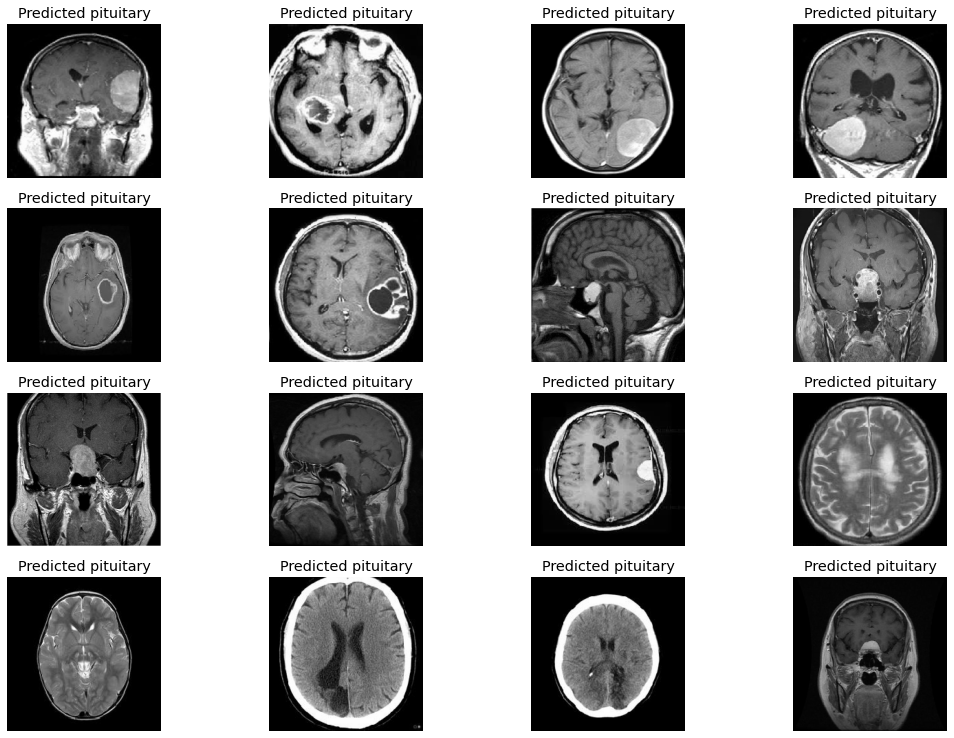

In [35]:
from keras.preprocessing import image 

rand_ims_dir = os.path.join('/content/drive/MyDrive/random_mri')

random_images = os.listdir(rand_ims_dir)

IMG_SIZE = 224

batch_holder = np.zeros((16, IMG_SIZE, IMG_SIZE, 3)) # folder contains 16 images 
for i,img in enumerate(random_images):
    img= image.load_img(os.path.join(rand_ims_dir,img), target_size=(IMG_SIZE,IMG_SIZE))
    batch_holder[i, :] = img

result = model.predict(batch_holder)
arg_result = np.argmax(result, axis=1)
# 
print("result vector: ", result)
print ("arg_result type: ", type(arg_result))
print ("arg_result :", arg_result)
# 
fig = plt.figure(figsize=(18, 13))
 
for i,img in enumerate(batch_holder):
    fig.add_subplot(4,4, i+1)
    plt.axis("off")
    if result[i][0]==0:
        plt.title("Predicted glioma")
    elif result[i][1]==1:
        plt.title("Predcted meningioma")
    elif result[i][1]==2:
        plt.title("Predicted healthy")
    else:
        plt.title("Predicted pituitary")
    plt.axis("off")    
    plt.imshow(img/256.)

***Visualizing Conv Layer Outputs***

I will describe two methods to visualize the conv. layer outputs, they are rather similar but, process of tiling the images are different. 

**1st Method: Stack the Layer Outputs Horizontally:**

To get outputs from the selected layers, we will use Keras layer.output method. Then append the outputs on a list. 

Next step is important, as we will instantiate a new model, which will take a random image as input and the outputs will be the selected conv. layer outputs.

If you remember the input of our original model (VGG like), it was batches of images with input size (None, 224, 224, 3). We will select the same input size dimension but as we just want to process only 1 randomly selected image at a time, our batch size will be 1. First, let’s select an image randomly, we will do that using random.choice, which returns a random element from a non-empty sequence.

In the next step, we want to resize this image and convert this image to a numpy array and finally, reshape it to a consistent format (batch size, height, width, channel). Let’s do that using Keras load_img, Keras img_to_array and numpy modules.

Once we have processed the image in a format that is suitable as an input for our model, let’s generate predictions from the model for the selected layers.

Now comes the part of arranging these predictions in such way, so that it is possible to visualize the effect of each filter on those selected layers. This part is little tricky and we need to unleash our playfulness with numpy. Let me give a brief outline of how we can proceed. If you look back to the model.summary() then you will get the overview of the shapes and the last element of the tuple is the number of filters and, first/second element of the tuple is the height/width of the image. First we create grids of zeroes with shape (height, height*number of filters), so that later we can stack the outputs horizontally. Next, we loop over the number of filters. We need to remember that the batch size is 1 so, to select a particular filter output from a selected layer we do this.

Then we standardize and post process the output of the filters to make it visually recognizable. Finally, we stack the filter output in the display grid that we created before (grids of zeros). Using matplotlib imshow, we can visualize the effect of each filters on a particular layer where the images will be stacked side by side.

layer names list: ['conv2d_1', 'block0_conv2', 'block0_pool1', 'block1_conv1', 'block1_conv2', 'block1_pool1', 'block2_conv1', 'block2_conv2', 'block2_pool1', 'block3_conv1', 'block3_pool', 'flatten_1', 'dense_2', 'Dropout_1', 'dense_3']
[1, 6, 7]
random file name:  /content/drive/MyDrive/random_mri/GLIOMA_3.jpg
shape of selected image : (224, 224, 3)


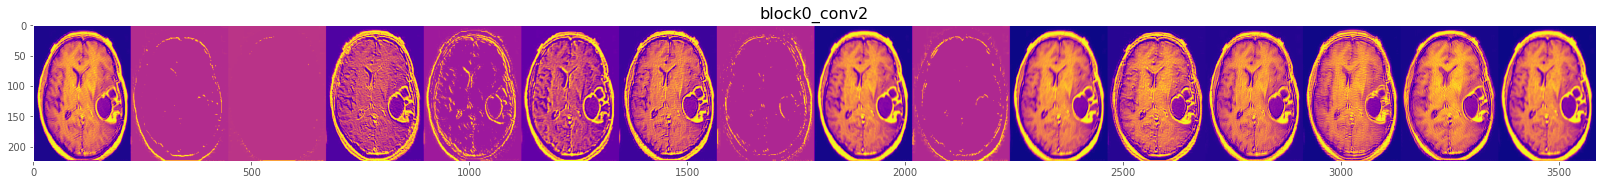

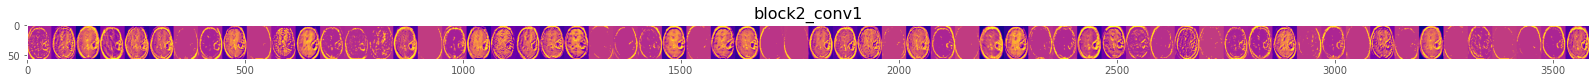

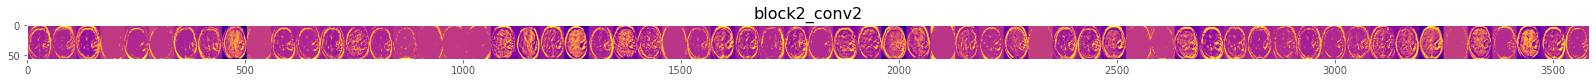

In [36]:
from keras.preprocessing.image import load_img, img_to_array
import random
layer_names_list = [layr.name for layr in model.layers]
print ("layer names list:", layer_names_list)

selected_layers = ['block0_conv2', 'block2_conv1', 'block2_conv2']

matched_indices = [i for i, item in enumerate(layer_names_list) if item in selected_layers]

print (matched_indices)


selected_layers_outputs = []

for lr in range(len(matched_indices)):
  outputs = model.layers[matched_indices[lr]].output
  selected_layers_outputs.append(outputs)


visual_model = models.Model(inputs = model.input, outputs = selected_layers_outputs)

train_glioma_images = os.listdir(train_glioma_dir)
train_pituitary_images = os.listdir(train_pituitary_dir)
train_no_tumor_images = os.listdir(train_no_tumor_dir)
train_meningioma_images = os.listdir(train_meningioma_dir)

glioma_files = [os.path.join(train_glioma_dir, f) for f in train_glioma_images]
pituitary_files = [os.path.join(train_pituitary_dir, g) for g in train_pituitary_images]
no_tumor_files = [os.path.join(train_no_tumor_dir, g) for g in train_no_tumor_images]
meningioma_files = [os.path.join(train_meningioma_dir, g) for g in train_meningioma_images]

#random_glio_pit_no_mening = random.choice(glioma_files + pituitary_files+no_tumor_files+meningioma_files)
random_glio_pit_no_mening = '/content/drive/MyDrive/random_mri/GLIOMA_3.jpg'
print ("random file name: ", random_glio_pit_no_mening)

rand_img = load_img(random_glio_pit_no_mening, target_size=(224, 224))
rand_img_arr = img_to_array(rand_img)

print ("shape of selected image :", rand_img_arr.shape)

x_in = np.reshape(rand_img_arr, (1, 224, 224, 3)) # batch size 1


selected_feature_maps = visual_model.predict(x_in)


for lr_name, feat_map in zip(selected_layers, selected_feature_maps):
  n_filters = feat_map.shape[-1]
  n_size = feat_map.shape[1]
  display_grid = np.zeros((n_size, n_size * n_filters))
  for i in range(n_filters):
    y = feat_map[0, :, :, i]
    y = y - y.mean()
    y = y/y.std()
    y = y*80
    y = y + 128
    y = np.clip(y, 0, 255).astype('uint8')
    display_grid[:, i * n_size : (i+1) * n_size] = y
  scale = 20./n_filters
  plt.figure(figsize=(scale * n_filters * 1.4, scale * 2))
  plt.title(lr_name, fontsize=16)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='plasma')
  plt.savefig('/content/drive/MyDrive/glioma_visual_%s.png'%(lr_name), dpi=300)

Here, we could see that the filters in the 2nd layer (block0_conv2) of the model where it sees the complete input (224, 224), mostly look for the basic shape of the brain. But, as we go deeper the input size reduces, for example in block2_conv2 layer the shape of the image is (60, 60) and, here the visual information are almost unrecognizable but features related to the class of the image are caught by the filters. Also you see the number of sparse filters increasing as we go deep in the network because, with increasing number of filters in each layer, the pattern encoded by the previous layer filters are not seen in the current layer. That’s why almost always you will see the in the first layer all filters are activated but from the second layer on sparsity increases.

**2nd Method:** 
Here we take one benefit from the number of filters used in each layer and that is, they are all multiples of 16. So number of columns of each grid will be 16 and, the number of rows will depend on the number of filters used in the selected Convolutional layer. So, number of columns (ncols) will be given by = number of filters/16. Here, our grid of zeros will have shape (height*ncols, 16 * width). Consider that the height and width of the images are same in every layer.

layer names list: ['conv2d_1', 'block0_conv2', 'block0_pool1', 'block1_conv1', 'block1_conv2', 'block1_pool1', 'block2_conv1', 'block2_conv2', 'block2_pool1', 'block3_conv1', 'block3_pool', 'flatten_1', 'dense_2', 'Dropout_1', 'dense_3']
[1, 4, 7]


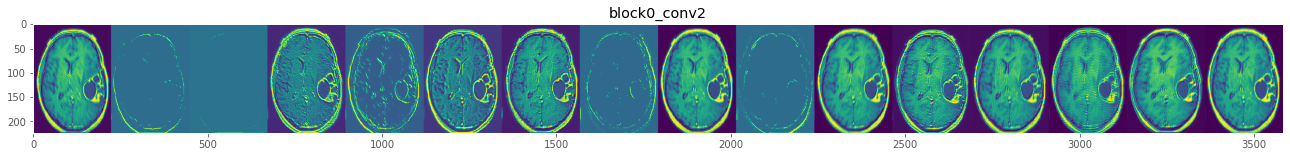

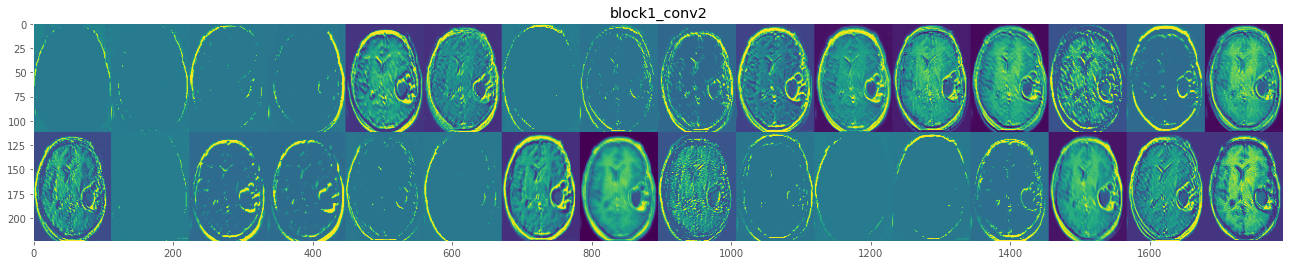

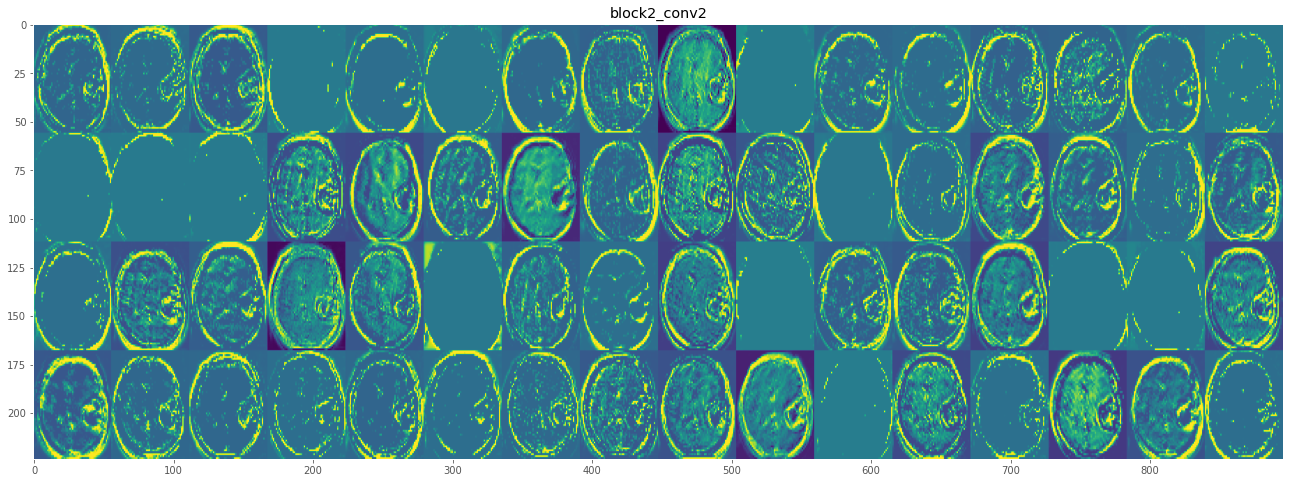

In [37]:
layer_names_list = [layr.name for layr in model.layers]
print ("layer names list:", layer_names_list)



selected_layers1 = ['block0_conv2', 'block1_conv2', 'block2_conv2']

matched_indices1 = [j for j, item in enumerate(layer_names_list) if item in selected_layers1]

print (matched_indices1)


selected_layers_outputs1 = []

for lr1 in range(len(matched_indices1)):
  outputs1 = model.layers[matched_indices1[lr1]].output
  selected_layers_outputs1.append(outputs1)



new_visual_model = models.Model(inputs = model.input, outputs = selected_layers_outputs1)

selected_feature_maps1 = new_visual_model.predict(x_in)

# select the image same as before and then reshape to make it compatible for keras model input

images_per_row = 16

for lr_name1, feat_map1 in zip(selected_layers1, selected_feature_maps1):
  n_filters1 = feat_map1.shape[-1]
  n_size1 = feat_map1.shape[1]
  n_cols = n_filters1 // images_per_row
  display_grid1 = np.zeros((n_size1 * n_cols, images_per_row * n_size1))
  for col in range(n_cols):
    for row in range(images_per_row):
      chan_img = feat_map1[0, :, :, col*images_per_row + row]
      chan_img = chan_img - chan_img.mean()
      chan_img = chan_img / chan_img.std()
      chan_img = chan_img * 64
      chan_img = chan_img + 128
      chan_img = np.clip(chan_img, 0, 255).astype('uint8')
      display_grid1[col * n_size1 : (col+1) *  n_size1, row * n_size1 : (row+1) * n_size1] = chan_img
  scale1 = 1./n_size1
  plt.figure(figsize=(scale1 * display_grid1.shape[1]*1.4, scale1 * display_grid1.shape[0] * 2.))
  plt.title(lr_name1)
  plt.grid(False)
  plt.imshow(display_grid1, aspect='auto', cmap='viridis')
  plt.savefig('/content/drive/MyDrive/glioma_visual2_%s.png'%(lr_name1), dpi=300)

With this representation you can clearly see how the filters in the deeper layers in our model concentrate on specific features of the brain, like the its shape, the contourns, the cortical area, etc.